##  <u> ***Data Modelling***  </u>

In [ ]:
%run 2_DataCleaning&Preperations.ipynb

* #### *Import Needed Libraries :*

In [74]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor,XGBRFRegressor
import warnings
from catboost import CatBoostRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from hyperopt import fmin,tpe,STATUS_OK,Trials,hp


---

### ***A.*** <u>***Frequency as a Target Feature :***</u>

#### ***A.1***<br> <u>***Basic Models Comparison :***</u>

##### ***A.1.1***<br> <u>***Models :***</u>

In [81]:
models = {
                "Random Forest": RandomForestRegressor(),
                "Decision Tree": DecisionTreeRegressor(),
                "Gradient Boosting": GradientBoostingRegressor(),
                "XGBRFRegressor":XGBRFRegressor(),
                "CatBoosting Regressor": CatBoostRegressor(verbose=False),
                "AdaBoost Regressor": AdaBoostRegressor(),
            }

##### ***A.1.2***<br> <u>***Prepare Date :***</u>

In [75]:
x_frequincy=df.drop("frequincy",axis=1)
y_frequincy=df["frequincy"]

xtrain_full,xtest_full, ytrain, ytest = train_test_split(x_frequincy, y_frequincy, train_size=0.8, test_size=0.2,random_state=0)

numerical_cols = [col for col in xtrain_full.columns if xtrain_full[col].dtype in ['int64', 'float64']]
categorical_cols =[col for col in xtrain_full.columns if  xtrain_full[col].dtype == "object"]

my_cols = categorical_cols + numerical_cols
xtrain = xtrain_full[my_cols].copy()
xtest = xtest_full[my_cols].copy()

categorical_transformer = Pipeline(steps=[#('imputer', SimpleImputer(strategy='most_frequent')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        #('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

##### ***A.1.3***<br> <u>***Apply Models :***</u>

In [76]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square


model_list = []
r2_list =[]
mae_list=[]
rmse_list=[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model =my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('melbourne_model', model)# or ('melbourne_model', RandomForestRegressor(random_state=0,n_estimators=50)) 
                             ])
    model.fit(xtrain, ytrain) 

    y_train_pred = model.predict(xtrain)
    y_test_pred = model.predict(xtest)

    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(ytrain, y_train_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(ytest, y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    rmse_list.append(model_test_rmse)
    mae_list.append(model_test_mae)
    
    print('='*35)
    print('\n')



Random Forest
Model performance for Training set
- Root Mean Squared Error: 2.3573
- Mean Absolute Error: 0.1488
- R2 Score: 0.4247
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 2.4961
- Mean Absolute Error: 0.1601
- R2 Score: -1.1917


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 2.2392
- Mean Absolute Error: 0.1340
- R2 Score: 0.4809
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 3.4848
- Mean Absolute Error: 0.1693
- R2 Score: -3.2719


Gradient Boosting
Model performance for Training set
- Root Mean Squared Error: 2.9650
- Mean Absolute Error: 0.1886
- R2 Score: 0.0898
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1.5435
- Mean Absolute Error: 0.1616
- R2 Score: 0.1619


XGBRFRegressor
Model performance for Training set
- Root Mean Squared Error: 2.4229
- Mean Absolute Error: 0.1638
- R2 Score: 0.3922
------------

##### ***A.1.4***<br> <u>***Best Model :***</u>

In [77]:
pd.DataFrame(list(zip(model_list,rmse_list,mae_list)), 
             columns=['Model Name', 'rmse_Score','mae_Score']).sort_values(by=["mae_Score"],ascending=True)

,Model Name,rmse_Score,mae_Score
0,Random Forest,2.496066,0.160073
2,Gradient Boosting,1.543545,0.161563
3,XGBRFRegressor,2.927967,0.162677
1,Decision Tree,3.484821,0.169282
4,CatBoosting Regressor,3.221000,0.178402
5,AdaBoost Regressor,3.552744,0.514650


##### ***A.1.5***<br> <u>***Apply Best Model :***</u>

In [78]:
RandomForestRegressor_model = RandomForestRegressor()
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('melbourne_model', RandomForestRegressor_model)# or ('melbourne_model', RandomForestRegressor(random_state=0,n_estimators=50)) 
                             ])
my_pipeline.fit(xtrain, ytrain)
preds = my_pipeline.predict(xtest)
score = mean_absolute_error(ytest, preds)
print('MAE:', score)
score = r2_score(ytest, preds)*100
print(" Accuracy of the model is %.2f" %score)

MAE: 0.16157286047609706
 Accuracy of the model is -124.70


##### ***A.1.6***<br> <u>***Visualize Best Model :***</u>

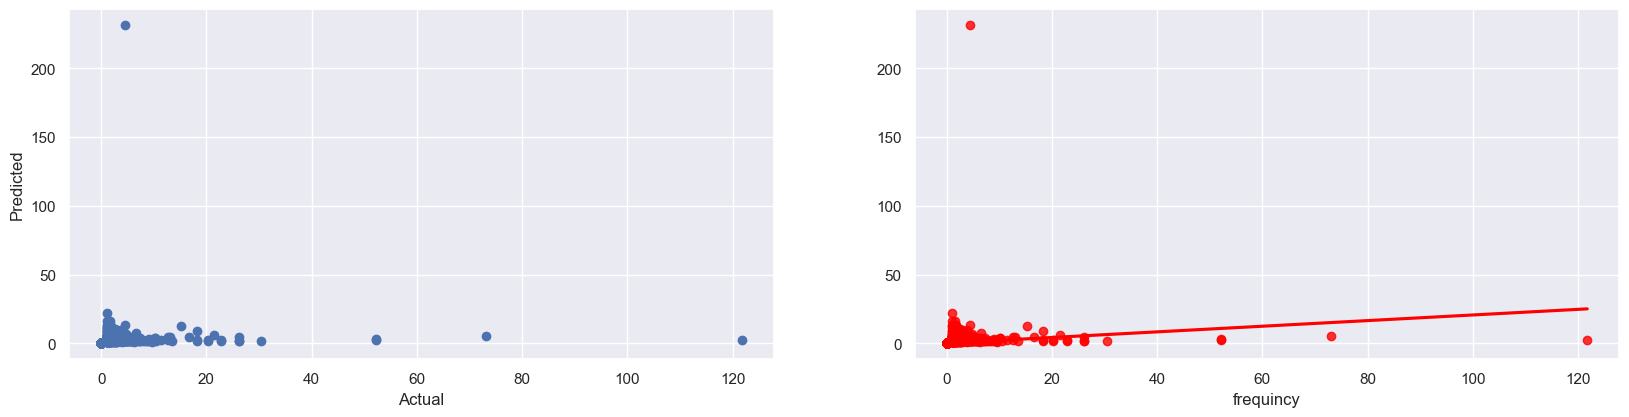

In [80]:
plt.subplot(221)
plt.scatter(ytest,preds);

plt.xlabel('Actual');
plt.ylabel('Predicted');

plt.subplot(222)
sns.regplot(x=ytest,y=preds,ci=None,color ='red');

#### ***A.2***<br> <u>***Hyperopt Models Comparison :***</u>

##### ***A.2.1***<br> <u>***Create Spaces for each model :***</u>

In [26]:
space_rf = {
    'n_estimators': hp.choice('n_estimators', range(10, 200)),
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
    }

space_dt = {
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
    }

space_XGBRFRegressor = {
  'colsample_bynode': hp.uniform("colsample_bynode", 0.5,1), 
  "learning_rate": hp.uniform("learning_rate", 0, 1),
  'max_depth': hp.choice("max_depth", np.arange(1,20,1)),
  "num_parallel_tree": 100,
  "subsample": hp.uniform("subsample", 0.5,1)
}

space_catboost = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'depth': hp.choice('depth', range(1, 12)),
    'iterations': hp.choice('iterations', range(50, 200)),
}

space_adaboost = {
    'n_estimators': hp.choice('n_estimators', range(50, 200)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 1.0),
}

space_gradientboost = {
    'n_estimators': hp.choice('n_estimators', range(50, 200)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'max_depth': hp.choice('max_depth', range(1, 12)),
}

##### ***A.2.2***<br> <u>***Apply hyperopt :***</u>

In [42]:
def model_catboost(space_catboost):
    model_opt = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("CatBoostRegressor",CatBoostRegressor(
                                    learning_rate=float(space_catboost['learning_rate']),
                                    depth=int(space_catboost["depth"]),                                                       
                                    iterations=int(space_catboost['iterations'])
                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            } 

#####################################################################

def model_rf(space_rf):
    model_opt = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("RandomForestRegressor",RandomForestRegressor(
                                    n_estimators=int(space_rf['n_estimators']),
                                    max_depth=int(space_rf["max_depth"])                                                       
                                    #criterion=str(space_rf['criterion'])
                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            }   


#####################################################################

def model_gboost(space_gradientboost):
    model_opt = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("GradientBoostingRegressor",GradientBoostingRegressor(
                                    n_estimators=int(space_gradientboost['n_estimators']),
                                    learning_rate=float(space_gradientboost["learning_rate"]),                                           
                                    max_depth=int(space_gradientboost['max_depth'])
                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            } 

#####################################################################

def model_XGBRFRegressor(space_XGBRFRegressor):
    model_opt = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("XGBRFRegressor",XGBRFRegressor(
                                    colsample_bynode=float(space_XGBRFRegressor['colsample_bynode']),
                                    learning_rate=float(space_XGBRFRegressor["learning_rate"]),                                           
                                    max_depth=int(space_XGBRFRegressor['max_depth']),
                                    num_parallel_tree=int(space_XGBRFRegressor['num_parallel_tree']),
                                    subsample=float(space_XGBRFRegressor['subsample'])
                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            }       

#####################################################################

def model_adaboost(space_adaboost):
    model_opt = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("AdaBoostRegressor",AdaBoostRegressor(
                                    n_estimators=int(space_adaboost['n_estimators']),
                                    learning_rate=float(space_adaboost["learning_rate"])
                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            }       

In [43]:
best_model_catboost = fmin(fn=model_catboost, space=space_catboost, algo=tpe.suggest, max_evals=50)
best_model_rf = fmin(fn=model_rf, space=space_rf, algo=tpe.suggest, max_evals=50)
best_model_gboost = fmin(fn=model_gboost, space=space_gradientboost, algo=tpe.suggest, max_evals=50)
best_model_XGBRFRegressor = fmin(fn=model_XGBRFRegressor, space=space_XGBRFRegressor, algo=tpe.suggest, max_evals=50)
best_model_adaboost = fmin(fn=model_adaboost, space=space_adaboost, algo=tpe.suggest, max_evals=50)

100%|██████████| 50/50 [01:21<00:00,  1.64s/trial, best loss: 0.28424209462063454]


##### ***A.2.3***<br> <u>***hyperopt best params:***</u>

In [44]:
print("best_model_catboost",best_model_catboost)
print("best_model_rf",best_model_rf)
print("best_model_gboost",best_model_gboost)
print("best_model_XGBRFRegressor",best_model_XGBRFRegressor)
print("best_model_adaboost",best_model_adaboost)

best_model_catboost {'depth': 1, 'iterations': 74, 'learning_rate': 0.03940650784205581}
best_model_rf {'criterion': 0, 'max_depth': 3, 'n_estimators': 1}
best_model_gboost {'learning_rate': 0.10992415172319682, 'max_depth': 3, 'n_estimators': 8}
best_model_XGBRFRegressor {'colsample_bynode': 0.85779412656548, 'learning_rate': 0.9888324230327836, 'max_depth': 4, 'subsample': 0.5014079447756978}
best_model_adaboost {'learning_rate': 0.5384782272949582, 'n_estimators': 47}


##### ***A.2.4***<br> <u>***Apply hyperopt best params:***</u>

In [61]:
def model_catboost_best(best_model_catboost ):
    y_CatBoostRegressor_best=[]
    model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("CatBoostRegressor",CatBoostRegressor(
                                    learning_rate=float(best_model_catboost ['learning_rate']),
                                    depth=int(best_model_catboost ["depth"]),                                                       
                                    iterations=int(best_model_catboost ['iterations'])
                                    ))

                                    ]).fit(xtrain,ytrain)  
    
    y_pred = model_opt_best.predict(xtest)
    y_CatBoostRegressor_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_catboost_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_catboost_best is %.2f" %score)

#####################################################################

def model_rf_best(best_model_rf):
    y_RandomForestRegressor_best=[]
    model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("RandomForestRegressor",RandomForestRegressor(
                                    n_estimators=int(best_model_rf['n_estimators']),
                                    max_depth=int(best_model_rf["max_depth"])                                                       
                                    #criterion=str(best_model_rf['criterion'])
                                    ))

                                    ]).fit(xtrain,ytrain)  
    
    y_pred = model_opt_best.predict(xtest)
    y_RandomForestRegressor_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_rf_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_rf_best is %.2f" %score) 

#####################################################################

def model_gboost_best(best_model_gboost):
    y_gboost_best=[]
    model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("GradientBoostingRegressor",GradientBoostingRegressor(
                                    n_estimators=int(best_model_gboost['n_estimators']),
                                    learning_rate=float(best_model_gboost["learning_rate"]),                                           
                                    max_depth=int(best_model_gboost['max_depth'])
                                    ))

                                    ]).fit(xtrain,ytrain)
    y_pred = model_opt_best.predict(xtest)
    y_gboost_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_gboost_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_gboost_best is %.2f" %score)

#####################################################################

def model_XGBRFRegressor_best(best_model_XGBRFRegressor):
    y_XGBRFRegressor_best=[]
    model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("XGBRFRegressor",XGBRFRegressor(
                                    colsample_bynode=float(best_model_XGBRFRegressor['colsample_bynode']),
                                    learning_rate=float(best_model_XGBRFRegressor["learning_rate"]),                                           
                                    max_depth=int(best_model_XGBRFRegressor['max_depth']),
                                    # num_parallel_tree=int(best_model_XGBRFRegressor['num_parallel_tree']),
                                    subsample=float(best_model_XGBRFRegressor['subsample'])
                                    ))

                                    ]).fit(xtrain,ytrain)
    
    y_pred = model_opt_best.predict(xtest)
    y_XGBRFRegressor_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_XGBRFRegressor_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_XGBRFRegressor_best is %.2f" %score)

#####################################################################

def model_adaboost_best(best_model_adaboost):
    y_adaboost_best=[]
    model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("AdaBoostRegressor",AdaBoostRegressor(
                                    n_estimators=int(best_model_adaboost['n_estimators']),
                                    learning_rate=float(best_model_adaboost["learning_rate"])
                                    ))

                                    ]).fit(xtrain,ytrain)
    
    y_pred = model_opt_best.predict(xtest)
    y_adaboost_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_adaboost_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_adaboost_best is %.2f" %score)
    

##### ***A.2.5***<br> <u>***Determine the best model and hyperopt best params:***</u>

In [ ]:
model_catboost_best(best_model_catboost )

In [63]:
model_rf_best(best_model_rf)

model_rf_best MAE: 0.15270296146062956
 Accuracy of the model_rf_best is 3.45


In [64]:
model_gboost_best(best_model_gboost)

model_gboost_best MAE: 0.1909323561208385
 Accuracy of the model_gboost_best is 15.40


In [65]:
model_XGBRFRegressor_best(best_model_XGBRFRegressor)

model_XGBRFRegressor_best MAE: 0.15561691284095006
 Accuracy of the model_XGBRFRegressor_best is 8.59


In [66]:
model_adaboost_best(best_model_adaboost)

model_adaboost_best MAE: 0.499566305204737
 Accuracy of the model_adaboost_best is -718.03


In [70]:
print(f"model_catboost_best(best_model_catboost ) ,has the lowest mae with 0.15215279995898695 with the best parameters:\n {best_model_catboost}" )

model_catboost_best(best_model_catboost ) ,has the lowest mae with 0.15215279995898695 with the best parameters:
 {'depth': 1, 'iterations': 74, 'learning_rate': 0.03940650784205581}
